# Comparison of Light Curve Data
$$m_x= -5 \log_{100}(F/F_0)$$
$$F/F_0 = 100^{-m_x / 5}$$

## To-do
1. read data
2. convert to rel. flux
3. normalize flux readings
4. normalize julian dates
4. plot with data we have


In [65]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.timeseries import BinnedTimeSeries

In [66]:
compare_dir = './analysis/comparison-data/'
tz_boo = pd.read_csv(compare_dir + 'TZ_Boo.csv')
cc_com = pd.read_csv(compare_dir + 'CC_Com.csv')

In [67]:
def rel_flux(mag):
    return 100 ** (-mag / 5)

# process data and append to column

def append_flux_column(df):
    mag_column = df['V Band dm']
    flux = rel_flux(mag_column)
    flux = flux / flux.max()
    df['V Band Rel Flux'] = flux
    return df

In [68]:
append_flux_column(tz_boo)

,HJD,V Band dm,V Band Rel Flux
0,2455343.371,-0.468,1.000000
1,2455343.373,-0.454,0.987188
2,2455343.375,-0.433,0.968278
3,2455343.377,-0.422,0.958517
4,2455343.379,-0.422,0.958517
5,2455343.381,-0.411,0.948855
6,2455343.384,-0.395,0.934975
7,2455343.386,-0.380,0.922147
8,2455343.388,-0.368,0.912011
9,2455343.390,-0.353,0.899498


In [69]:
append_flux_column(cc_com)

,HJD,V Band dm,V Band Rel Flux
0,57868.62375,0.230,0.088308
1,57868.62473,0.191,0.091538
2,57868.62570,0.153,0.094798
3,58590.99775,-0.206,0.131947
4,58591.00543,-0.090,0.118577
5,58591.00652,-0.058,0.115133
6,58849.28544,-2.403,0.998160
7,58849.28606,-2.405,1.000000
8,58849.28667,-2.402,0.997241
9,58873.53431,-0.237,0.135769


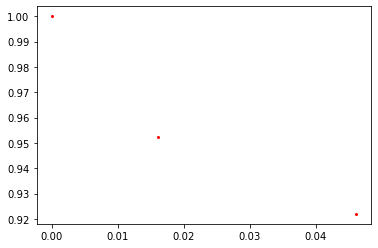

In [70]:
our_cc = BinnedTimeSeries.read(
    './analysis/results/cccom_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)
our_jd = our_cc.time_bin_start.jd - our_cc.time_bin_start.jd.min()
plt.plot(our_jd, our_cc['AP flux'] / our_cc['AP flux'].max(), 'r.', markersize=4, label='AP rel. flux')
# plt.plot(cc_com['HJD'] - cc_com['HJD'].min(), cc_com['V Band Rel Flux'], '.', markersize=4)

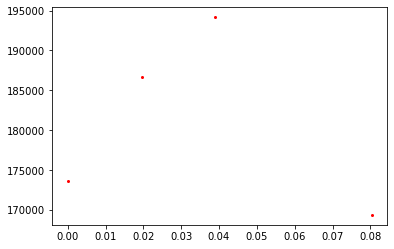

In [75]:
our_tz = BinnedTimeSeries.read(
    './analysis/results/tzboo_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)
# our_jd = our_tz.time_bin_start.jd - our_tz.time_bin_start.jd.min()
plt.plot(our_jd, our_tz['AP flux'], 'r.', markersize=4, label='AP rel. flux')
# plt.plot(cc_com['HJD'] - cc_com['HJD'].min(), cc_com['V Band Rel Flux'], '.', markersize=4)

$$\displaystyle - \frac{\phi^{2} a}{2} - \phi a b x - \frac{a b^{2} x^{2}}{2} + a$$
- $a^\prime = -ab^2 / 2$
- $b^\prime = -\phi a b$
- $c^\prime = a(1-\phi^2/2)$

In [95]:
from sympy import *
a, b, x, phi = symbols(r'a b x \phi')

expr = a * (1 - (b * x + phi) ** 2 / 2)
expr.expand()

-\phi**2*a/2 - \phi*a*b*x - a*b**2*x**2/2 + a

In [103]:
from lmfit.models import SineModel, QuadraticModel, Model

def second_order_cos(x, a, b, phi):
    return a * (1 - (b * x + phi) ** 2 / 2)

quad = QuadraticModel()
# quad = Model(second_order_cos)
rel_flux = our_tz['AP flux'] / our_tz['AP flux'].max()
param_guess = quad.guess(rel_flux, x=our_jd)
print(param_guess)
quad_fit = quad.fit(rel_flux, param_guess, x=our_jd)
# result = quad.fit(rel_flux, x=our_jd, a=5, b=5, phi=5)
# result.params['a'].value
quad_fit.params

Parameters([('a', <Parameter 'a', value=-69.1035476631917, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=5.335324996418381, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.8910592917421547, bounds=[-inf:inf]>)])


name,value,standard error,relative error,initial value,min,max,vary
a,-69.1035477,7.38807346,(10.69%),-69.1035476631917,-inf,inf,True
b,5.33532500,0.64259541,(12.04%),5.335324996418381,-inf,inf,True
c,0.89105929,0.01007611,(1.13%),0.8910592917421547,-inf,inf,True


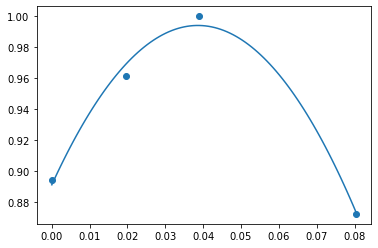

In [104]:
fit_domain = np.linspace(our_jd.min(), our_jd.max(), 100)
plt.plot(fit_domain, quad_fit.eval(x=fit_domain))
plt.scatter(our_jd, rel_flux)

In [110]:
a = quad_fit.params['a']
b = quad_fit.params['b']
c = quad_fit.params['c']
period = 2 * np.pi / np.sqrt(2 * a / (b ** 2 / (4 * a) - c))
period

0.5328646574082296

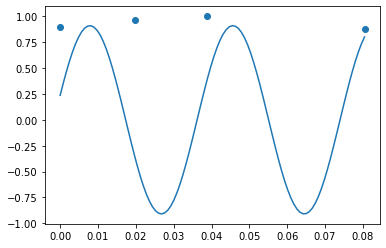

In [93]:
sine = SineModel()
sine_guess = sine.guess(rel_flux, x=our_jd)
sine_fit = sine.fit(rel_flux, sine_guess, x=our_jd)
fit_domain = np.linspace(our_jd.min(), our_jd.max(), 100)
plt.plot(fit_domain, sine_fit.eval(x=fit_domain))
plt.scatter(our_jd, rel_flux)